In [49]:
import yfinance as yf
import pandas as pd
import datetime as dt
import simfin as sf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('ggplot')

In [2]:
# First load the Simfin file containing the data

In [54]:
class Company():
    def __init__(self, ticker, market='us'):
        # Initialize the Simfin dataset
        sf.set_data_dir('C:Users\\Andi\\Desktop\\Udemy\\Python-Notebook\\Finance\\tickers')
        sf.set_api_key(api_key='free')
        
        # Attributes
        self._ticker = ticker
        self._company = yf.Ticker(self._ticker)
        self._market = market
        #self._market_cap
        #self._beta
        #self._shares_outstanding
        #self._growth_perp
        
        # Revenue
        self._revenue = self.income_sheet()['Revenue']
        
        self._growth_rate = self._revenue.pct_change(1)
        
        # Net Icome
        self._net_income = self.income_sheet()['Net Income']
        
         # Cash flow from operating activities (cahflow)
        self._CF_OA = self.cashflow()['Net Cash from Operating Activities']
        
         # Capital expenditures or also called Change in Fixed Assets & Intangibles (cashflow)
        self._CAPEX = self.cashflow()['Change in Fixed Assets & Intangibles']
        
        # Free cash flow computed from CF_OA - CAPEX (it is already negative CAPEX so we use a positive sign)
        self._FCF = self._CF_OA + self._CAPEX
        
        # Get the historical daily values since day 0
        self._history = self._company.history(period="max")
        self._history.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
        
        # Logaritmic return of the stcok since day 0: 
        self._log_return = np.log(self._history['Close']/self._history['Close'].shift(1))
        
        # Sharpe Ratio and Annual SR
        self._sr = round(self.expected_return()/self.volatility(),2)
        self._asr = round(self._sr*(252**0.5),2)
        
        # Expected Anual Volatility of the stock since day start_date
    def volatility(self, weights = 1):
        if weights == 1:
            return round(self._log_return.std()*252,2)
        return np.sqrt(np.dot(weights.T, np.dot(self._log_ret.cov()*252, weights)))
    
        # Expected anual return 
    def expected_return(self, weights=1):
        if weights == 1:
            return round(self._log_return.mean()*252,2)
        
        #else we have weights, i.e. we have more stocks
        return np.sum(self._log_return.mean()*weights)*252
        
    def normed_return(self, open_buy, start_date =0):
        if start_date !=0 and open_buy !=0:
            return self._history.loc[start_date:]['Close']/open_buy
        
        if start_date !=0 and open_buy ==0:
            return self._history.loc[start_date:]['Close']/self._history.loc[start_date]['Close']
        
        if start_date ==0 and open_buy ==0:
            return self._history.loc['Close']/self._history.iloc[0]['Close']
        
        return self._history['Close']/open_buy
        
      
    def open_position(self, start_date=0, allocation=1, amount_invested=1, open_buy=0):
        position = self.normed_return(open_buy, start_date)*amount_invested*allocation
        daily_return = position.pct_change(1)
        daily_return_percentage = round(daily_return*100,2)
        df = pd.concat([position, daily_return, daily_return_percentage], axis=1)
        df.columns = ['Position '+self._ticker, 'Daily Return', 'Daily Return %']
        return df
        
    def income_sheet(self, time='annual'):
        columns = ['Revenue', 'Cost of Revenue', 'Gross Profit', 'Operating Expenses', 'Income Tax (Expense) Benefit, Net', 
                   'Operating Income (Loss)','Net Income','Pretax Income (Loss)']
        income_sheet_df = sf.load_income(variant=time, market= self._market).loc[self._ticker][columns]
        income_sheet_df.fillna(0, inplace=True)
        
        return income_sheet_df
        
    def balance_sheet(self,time='annual'):
        balance_sheet_df = sf.load_balance(variant=time, market= self._market).loc[self._ticker, 'Cash, Cash Equivalents & Short Term Investments':]
        balance_sheet_df.fillna(0,inplace=True)
                                                                                    
    
    
    def cashflow(self,time='annual'):
        cash_flow_df = sf.load_cashflow(variant=time, market= self._market).loc[self._ticker, 'Net Income/Starting Line':]
        cash_flow_df.drop(['Change in Accounts Receivable','Change in Other', \
                           'Change in Accounts Payable', 'Change in Inventories'], axis = 1, inplace=True)
        cahs_flow_df = cash_flow_df.fillna(0, inplace=True)
        return cash_flow_df
        
    def info(self):
        return self._company.info
        
    def plot():
        pass
    
    def valuation_method(self, method ="DCF"):
        
        def DCF(self):
            # We use the Discounted Cash Flow valuation model in order to estimate the Intrinsic Value
            pass
        
        if method == 'DCF':
            pass
        
    
        def Earnings_valuation(self):
            pass
        
    
        
      
    @staticmethod
    def optimize_portfolio( stocks, amount_invested, sim=1500): # stocks is a list of Company objects ex: [aapl, air]
        #Preprocess the historical values in order to have the same length: we take the most recent date as starting date
        min_len = float('inf')
        index = 0
        for i in range(len(stocks)):
            if len(stocks[i]._history) < min_len:
                min_len = len(stocks[i]._history)
                index = i
        
        start_date = stocks[index]._history.index[0]
        
        # Assert the stocks have same length, i.e. same historical data
        for ele in [len(i._history.loc[start_date:]) for i in stocks]:
            assert ele == len(stocks[index]._history), "Historical data must have the same length"
        
        # Construct the Data frame Portfolio and another dataframe with the stocks_Close Close Price
        portfolio = pd.DataFrame({})
        stocks_Close = pd.DataFrame({})
        for i in range(len(stocks)):
            portfolio[stocks[i]._ticker+' Position'] = stocks[i].open_position(start_date=start_date)['Position '+stocks[i]._ticker]
            stocks_Close[stocks[i]._ticker+' Close'] = stocks[i]._history['Close']
            
       
        # Print the portfolio
        print('Portfolio stocks: ')
        for ele in stocks:
            print( "%s " %ele._ticker)
        
        # Define the Total position of your portfolio
        portfolio['Total Position'] = portfolio.sum(axis=1)
        # The Daily return
        portfolio['Daily return'] = portfolio['Total Position'].pct_change(1)
        portfolio['Daily return %'] = round(portfolio['Daily return']*100,2)
        
        # Define the logarithmic daily return wrt the stocks Close price (easier to work with the log one)
        stocks_log_dr = np.log(stocks_Close/stocks_Close.shift(1))
        
        
        # Defining the arrays that will contain the values
        allocation_arr = np.zeros((sim, len(stocks)))
        ex_return_arr = np.zeros(sim)
        volatility_arr = np.zeros(sim)
        sharpe_arr = np.zeros(sim)
        
        #Lunch the simulations
        for simu in range(sim):
            #Generate a random allocation/WEIGHTS
            allocation = np.array(np.random.random(len(stocks)))
            # Rebalance the weights such that their sum is = 1
            allocation = allocation/np.sum(allocation)
            # Assign the current allocation to the array
            allocation_arr[simu, :]= allocation
            
            # EXPECTED RETURN 
            ex_return_arr[simu] = np.sum(stocks_log_dr.mean()*allocation)*252
            
            # EXPECTED VOLATILITY
            volatility_arr[simu] = np.sqrt(np.dot(allocation.T, np.dot(stocks_log_dr.cov()*252, allocation)))
            
            # SHARPE RATIO
            sharpe_arr[simu] = ex_return_arr[simu]/volatility_arr[simu]
            
        # MAX SR
        print("The maximal value of Sharpe Ration is: %f" %sharpe_arr.max())
        
        # Find the optimal values of return and volatility that gives the max SR 
        optimal_return = ex_return_arr[sharpe_arr.argmax()]
        optimal_volatility = volatility_arr[sharpe_arr.argmax()]
        
        # OPTIMAL ALLOCATION
        print("The optimal allocation is: ")
        i = 0
        for ele in allocation_arr[sharpe_arr.argmax(), :]:
            print(stocks[i]._ticker +':'+ str(round(ele,2)))
            i +=1
            
        # Print RETURN vs VOLATILITY with SR colorbar
        plt.figure(figsize=(12,8))
        plt.scatter(volatility_arr, ex_return_arr, c= sharpe_arr, cmap='plasma')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Return')

        plt.scatter(optimal_volatility, optimal_return, c='red', s=50, edgecolors='black')
        
        
        return
    
    def estimate(self, n_years, method='linear'):
        
        def linear():
            pass
        
        def DNN():
            pass

In [59]:
aapl = Company("AAPL")
goo = Company("GOOG")
mic = Company("MSFT")

Dataset "us-income-annual" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-income-annual" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-income-annual" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-income-annual" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-income-annual" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-income-annual" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-annual" on disk (7 days old).
- Loading from disk ... Done!


In [62]:
aapl._market


'us'

In [60]:
stocks = [goo, aapl, mic]

Portfolio stocks: 
GOOG 
AAPL 
MSFT 
The maximal value of Sharpe Ration is: 1.047878
The optimal allocation is: 
GOOG:0.26
AAPL:0.74
MSFT:0.01


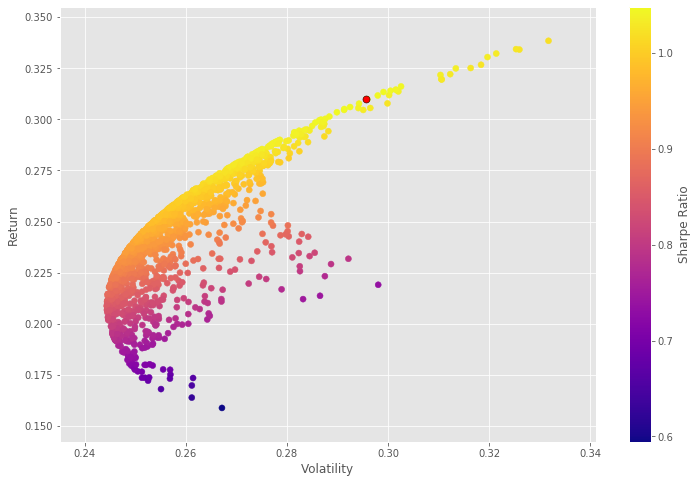

In [61]:
po = aapl.optimize_portfolio(stocks, 2)

In [211]:
po

,GOOG Position,AAPL Position
Date,,
2004-08-19,1.000000,1.000000
2004-08-20,1.079430,1.002931
2004-08-23,1.090293,1.012049
2004-08-24,1.045146,1.040378
2004-08-25,1.056408,1.076197
...,...,...
2020-11-24,35.389877,245.444819
2020-11-25,35.440896,247.277611
2020-11-27,35.876245,248.471051


In [144]:
index

1

In [145]:

start_date

Timestamp('2004-08-19 00:00:00')

In [170]:
goo._history

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655,44871300
2004-08-20,50.316402,54.336334,50.062355,53.952770,22942800
2004-08-23,55.168217,56.528118,54.321388,54.495735,18342800
2004-08-24,55.412300,55.591629,51.591621,52.239193,15319700
2004-08-25,52.284027,53.798351,51.746044,52.802086,9232100
...,...,...,...,...,...
2020-11-24,1730.500000,1771.599976,1727.689941,1768.880005,1578000
2020-11-25,1772.890015,1778.540039,1756.540039,1771.430054,1045800
2020-11-27,1773.089966,1804.000000,1772.439941,1793.189941,884900


In [134]:
range(len(stocks))

range(0, 2)

In [157]:
data = aapl._history.pop('Open')

In [167]:
data= pd.DataFrame({})

In [171]:
data['fgd'] = aapl._history['Low']

In [172]:
data

,fgd
Date,
1980-12-12,0.100266
1980-12-15,0.095035
1980-12-16,0.088059
1980-12-17,0.090239
1980-12-18,0.092855
...,...
2020-11-24,112.589996
2020-11-25,115.169998
2020-11-27,116.220001


In [4]:
arr = [1,2,3,4,5]

In [5]:
for ele in arr[2:]:
    print(ele)

3
4
5


In [31]:
arr[0]

1